In [1]:

"""
make_plots_Vamana.py

Part of the data release: https://zenodo.org/record/5650062

Authors: Vaibhav Tiwari on behalf of the LIGO Scientific Collaboration, Virgo Collaboration and KAGRA Collaboration

This software is provided under license: Creative Commons Attribution 4.0
International (https://creativecommons.org/licenses/by/4.0/legalcode) and  is provided as-is.

This script creates Figures 2, 9, and 19 in the companion paper

"""
import h5py, json
import scipy.stats as ss
from scipy.signal import savgol_filter
import numpy as np
import pickle

import seaborn
import mpl_utils
import matplotlib.pyplot as plt
from matplotlib.ticker import FormatStrFormatter
import sys

params = {'text.usetex' : 'True',
          'font.family' : 'serif', 
          'font.serif'  : 'cm',
          'legend.fontsize': 'large',
          'axes.labelsize': 'large',
          'axes.titlesize':'large',
          'xtick.labelsize':'large',
          'ytick.labelsize':'large','font.size':15}
plt.rcParams.update(params)
inches_to_cm = 2.54
figsize = (40/inches_to_cm, 13/inches_to_cm)
dpi = 300
cols = {}
cols['FM'] = 'peru'
cols['PP'] = "#4d9221"
cols['PS'] = "#1f78b4"
cols['BGP'] = "#4d9221"
cols['PP'] = "violet"

def read_results(fin):
    """ 
    Read a result file
    fin: The path to the file
    
    Returns
    -------
    Dictionary containing the data
    """
    with h5py.File(fin, 'r') as inp:
    
        run_data = {}
        key = 'args_sampler'
        run_data[key] = {}
        for k in inp[key].keys():
            run_data[key][k] = inp[key][k][()]
        key = 'args_ppd'
        run_data[key] = {}
        for k in inp[key].keys():
            run_data[key][k] = inp[key][k][()]
        key = 'posteriors'
        run_data[key] = {}
        for k in inp[key].keys():
            run_data[key][k] = inp[key][k][()]
        key = 'ppd'
        run_data[key] = {}
        for k in inp[key].keys():
            run_data[key][k] = inp[key][k][()]

    return run_data

def get_DiffRate_intervals(pdfs, rates):
    """ 
    Combines rate and density measurement to return credible 
    intervals for differnetial rate

    Parameters
    ----------
    pdfs: Posterior density
    rate: Merger rate
    """
    
    dRd = rates * np.array(pdfs).T
    p5 = np.percentile(dRd, 5., axis = 1)
    p25 = np.percentile(dRd, 25., axis = 1)
    p50 = np.percentile(dRd, 50., axis = 1)
    p75 = np.percentile(dRd, 75., axis = 1)
    p95 = np.percentile(dRd, 95., axis = 1)
    
    return p5, p25, p50, p75, p95




In [4]:
PATH = '/Volumes/Andromeda2/GWTC-3_paper/GWTC-3-population-data/'

sys.path.append(PATH)




In [38]:
import sys
sys.path.append('../../Scripts')
def layoutAxes(ax, nameX='', nameY='', \
               labelSizeMajor = 10, fontsize = 25, second=False, labelpad=None, setMinor=True):
    """
    Tiny code to do the layout for axes in matplotlib
    """
    tickLengthMajor = 10
    tickLengthMinor = 5
    tickWidthMajor  = 1.5
    tickWidthMinor  = 1.5
    
    #rc('axes', linewidth=2)
    #label1 always refers to first axis not the twin 
    if not second:
        for tick in ax.xaxis.get_major_ticks():
            tick.label1.set_fontsize(fontsize)
            #tick.label1.set_fontweight('bold')
        for tick in ax.yaxis.get_major_ticks():
            tick.label1.set_fontsize(fontsize)
            #tick.label1.set_fontweight('bold')
    if second:
        for tick in ax.xaxis.get_major_ticks():
            tick.label2.set_fontsize(fontsize)
            #tick.label1.set_fontweight('bold')
        for tick in ax.yaxis.get_major_ticks():
            tick.label2.set_fontsize(fontsize)
            #tick.label1.set_fontweight('bold')
    for axis in ['top','bottom','left','right']:
        ax.spines[axis].set_linewidth(1.2)
    ax.tick_params(length=tickLengthMajor, width=tickWidthMajor, which='major')
    ax.tick_params(length=tickLengthMinor, width=tickWidthMinor, which='minor')
    ax.set_xlabel(nameX, fontsize=fontsize,labelpad=labelpad)#,fontweight='bold')
    ax.set_ylabel(nameY, fontsize=fontsize,labelpad=labelpad)#, fontweight='bold')    
    
    if setMinor==True:
        # add minor ticks:
        ax.xaxis.set_minor_locator(AutoMinorLocator())
        ax.yaxis.set_minor_locator(AutoMinorLocator())

    return ax


# from PostProcessingScripts import * 

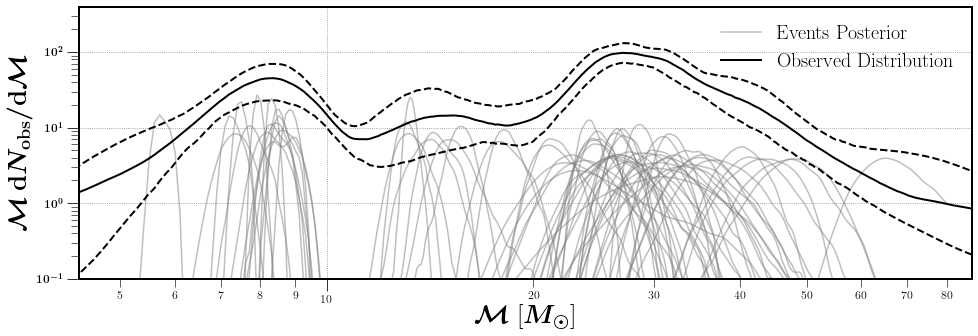

In [44]:
m1_ax = {}
mch_ax = {}
dRdm1 = {}
dRdmch = {}
pmch = {}
#Read files needed to make plots
fname =  PATH +'analyses/Vamana/posteriors/o1o2o3_sfr_1pz_rnp_ifar_1peryear_ng11.hdf5'
results = read_results(fname)
nobs = results['args_sampler']['nobs']
m1_ax['FM'] = results['args_ppd']['mass_ax']
mch_ax['FM'] = results['args_ppd']['mch_ax']
post_pdfs_mch = results['ppd']['post_pdf_mch']
post_pdfs_mass1 = results['ppd']['post_pdf_mass1']
rate = results['posteriors']['rate']
dRdmch['FM'] = (post_pdfs_mch.T * rate).T
dRdm1['FM'] = (post_pdfs_mass1.T * rate).T
dRdm1['FM']*=1.2**results['posteriors']['kappa']

#Read pp instead of bpl
fname = PATH  + 'analyses/PowerLawSpline/o1o2o3/spline_20n_mass_m_iid_mag_iid_tilt_powerlaw_redshift_mass_data_best_measured.h5'
with h5py.File(fname, 'r') as bulk:
    dRdm1['PS'] = bulk['lines']['mass_1'][()]

# fname = PATH +'analyses/PowerLawPeak/o1o2o3_mass_c_iid_mag_iid_tilt_powerlaw_redshift_mass_data_best_measured.h5'
# with h5py.File(fname, 'r') as bulk:
#     dRdm1['PP'] = bulk['lines']['mass_1'][:]
# m1_ax['PS'] = m1_ax['PP'] = np.linspace(2, 100, 1000)

with h5py.File(PATH +'analyses/Vamana/input/density_mchirp_standard_prior.hdf5', 'r') as bulk:
    mchax_pe = bulk['mchirp_ax'][()]
    density_mchirp_pe = bulk['density'][()]
    
with h5py.File(PATH +'analyses/BinnedGP/O1O2O3_IFAR4/bbh_dRdm1.hdf', 'r') as bulk:
    m1_ax['BGP'] = bulk['mass1'][()]
    dRdm1['BGP'] = bulk['dRdm1'][()]

fname =PATH + 'analyses/AdaptiveKDE/Datafiles/kde_m1_Mchirp_100samplesPEperevent_values/'
fname += 'Mchirp_pe100samples_per_event_standard_bbh_events_kde_data_Mchirp_kde__5thp_50thp_95thp_Nevents_Nalp_Nbw.txt'
datakde = np.loadtxt(fname)
mch_ax['kde'] = datakde.T[0]
pmch['kde'] = datakde.T

# #Plot - overview
xlim_low = 5.
xlim_high = 100.
fig = plt.figure(figsize = (16.0, 2 * 5.5))


# plot posterior samples 
plt.subplot(2, 1, 1)
ii = 0
for density in density_mchirp_pe:
    if ii == 0:
        plt.plot(mchax_pe, mchax_pe*density, color = 'grey', alpha = 0.5, label = 'Events Posterior')
        ii += 1
    else:
        plt.plot(mchax_pe, mchax_pe*density, color = 'grey', alpha = 0.5)

p50 = mch_ax['kde'] * nobs * pmch['kde'][3]
p5 = mch_ax['kde'] * nobs * pmch['kde'][2]
p95 = mch_ax['kde'] * nobs * pmch['kde'][4]
plt.plot(mch_ax['kde'], mch_ax['kde'] * nobs * pmch['kde'][3], color = 'k', linewidth = 2., label = 'Observed Distribution')
plt.plot(mch_ax['kde'], mch_ax['kde'] * nobs * pmch['kde'][2], color = 'k', linewidth = 2., linestyle = '--')
plt.plot(mch_ax['kde'], mch_ax['kde'] * nobs * pmch['kde'][4], color = 'k', linewidth = 2., linestyle = '--')
plt.yscale('log')
plt.xscale('log')
plt.xlim(2*xlim_low*0.25**(3/5), 2*xlim_high*0.25**(3/5))
plt.gca().xaxis.set_major_formatter(FormatStrFormatter("%.0f"))
plt.gca().xaxis.set_minor_formatter(FormatStrFormatter("%.0f"))
plt.ylim(1e-1, 3.0 * np.max(p95))
plt.legend(fontsize=20, frameon=False, loc='upper right')
plt.grid(ls=':',color='grey')

plt.xlabel('$\mathcal{M}$ [$M_\odot$]',fontsize=26, labelpad=-2)
plt.ylabel('$\mathcal{M} \, \mathrm{d}N_{\mathrm{obs}}/\mathrm{d} \mathcal{M}$',fontsize=26)
plt.savefig(PATH +'figures/pmch_only.png', dpi = dpi, bbox_inches = 'tight')



# print(np.sum(pmch['kde'][3]))


norm = np.trapz(pmch['kde'][3],mch_ax['kde'])
# print(norm)


# print(mch_ax['kde'])




In [ ]:
m1_ax = {}
mch_ax = {}
dRdm1 = {}
dRdmch = {}
pmch = {}
#Read files needed to make plots
fname =  PATH +'analyses/Vamana/posteriors/o1o2o3_sfr_1pz_rnp_ifar_1peryear_ng11.hdf5'
results = read_results(fname)
nobs = results['args_sampler']['nobs']
m1_ax['FM'] = results['args_ppd']['mass_ax']
mch_ax['FM'] = results['args_ppd']['mch_ax']
post_pdfs_mch = results['ppd']['post_pdf_mch']
post_pdfs_mass1 = results['ppd']['post_pdf_mass1']
rate = results['posteriors']['rate']
dRdmch['FM'] = (post_pdfs_mch.T * rate).T
dRdm1['FM'] = (post_pdfs_mass1.T * rate).T
dRdm1['FM']*=1.2**results['posteriors']['kappa']

#Read pp instead of bpl
fname = PATH  + 'analyses/PowerLawSpline/o1o2o3/spline_20n_mass_m_iid_mag_iid_tilt_powerlaw_redshift_mass_data_best_measured.h5'
with h5py.File(fname, 'r') as bulk:
    dRdm1['PS'] = bulk['lines']['mass_1'][()]

# fname = PATH +'analyses/PowerLawPeak/o1o2o3_mass_c_iid_mag_iid_tilt_powerlaw_redshift_mass_data_best_measured.h5'
# with h5py.File(fname, 'r') as bulk:
#     dRdm1['PP'] = bulk['lines']['mass_1'][:]
# m1_ax['PS'] = m1_ax['PP'] = np.linspace(2, 100, 1000)

with h5py.File(PATH +'analyses/Vamana/input/density_mchirp_standard_prior.hdf5', 'r') as bulk:
    mchax_pe = bulk['mchirp_ax'][()]
    density_mchirp_pe = bulk['density'][()]
    
with h5py.File(PATH +'analyses/BinnedGP/O1O2O3_IFAR4/bbh_dRdm1.hdf', 'r') as bulk:
    m1_ax['BGP'] = bulk['mass1'][()]
    dRdm1['BGP'] = bulk['dRdm1'][()]

fname =PATH + 'analyses/AdaptiveKDE/Datafiles/kde_m1_Mchirp_100samplesPEperevent_values/'
fname += 'Mchirp_pe100samples_per_event_standard_bbh_events_kde_data_Mchirp_kde__5thp_50thp_95thp_Nevents_Nalp_Nbw.txt'
datakde = np.loadtxt(fname)
mch_ax['kde'] = datakde.T[0]
pmch['kde'] = datakde.T

# #Plot - overview
xlim_low = 5.
xlim_high = 100.
fig = plt.figure(figsize = (16.0, 2 * 5.5))


# plot posterior samples 
plt.subplot(2, 1, 1)
ii = 0
for density in density_mchirp_pe:
    if ii == 0:
        plt.plot(mchax_pe, mchax_pe*density/10, color = 'grey', alpha = 0.5, label = 'Events Posterior')
        ii += 1
    else:
        plt.plot(mchax_pe, mchax_pe*density/10, color = 'grey', alpha = 0.5)

p50 = mch_ax['kde'] *  pmch['kde'][3]
p5 = mch_ax['kde'] *  pmch['kde'][2]
p95 = mch_ax['kde']  * pmch['kde'][4]
plt.plot(mch_ax['kde'], mch_ax['kde'] *  pmch['kde'][3], color = 'k', linewidth = 2., label = 'Observed Distribution')
plt.plot(mch_ax['kde'], mch_ax['kde'] *  pmch['kde'][2], color = 'k', linewidth = 2., linestyle = '--')
plt.plot(mch_ax['kde'], mch_ax['kde'] *  pmch['kde'][4], color = 'k', linewidth = 2., linestyle = '--')
plt.yscale('log')
plt.xscale('log')
plt.xlim(2*xlim_low*0.25**(3/5), 2*xlim_high*0.25**(3/5))
plt.gca().xaxis.set_major_formatter(FormatStrFormatter("%.0f"))
plt.gca().xaxis.set_minor_formatter(FormatStrFormatter("%.0f"))
plt.ylim(1e-1, 3.0 * np.max(p95))
plt.legend(fontsize=20, frameon=False, loc='upper right')
plt.grid(ls=':',color='grey')

plt.xlabel('$\mathcal{M}$ [$M_\odot$]',fontsize=20, labelpad=-2)
plt.ylabel('$\mathcal{M} \, \mathrm{d}N_{\mathrm{obs}}/\mathrm{d} \mathcal{M}$',fontsize=20)
plt.savefig(PATH +'figures/pmch_.png', dpi = dpi, bbox_inches = 'tight')







In [ ]:
print(np.sum(pmch['kde'][3]*0.11431431))

In [3]:
import numpy as np
import matplotlib.pyplot as plt
import sys
import h5py as h5

import numpy as np
from scipy import stats
import scipy


#Quick fudge to make import from ../Scripts work
sys.path.append('../../Scripts')

#Custom imports
# for color map
import seaborn as sns
# for reading datafiles 
import pandas as pd

# import script that has formation channel classification functions:
from PostProcessingScripts import * 

import ClassCOMPAS     as CC ###


from IPython.core.display import display, HTML
display(HTML("<style>.container { width:100% !important; }</style>"))


In [5]:
# nModels=17
# BPSnameslist = list(string.ascii_uppercase)[0:nModels]

# physicalNamesBPSmodelsWithEnter = [r'\textbf{fiducial}',\
#                            r'$\beta=0.25$', r'$\beta=0.5$',  r'$\beta=0.75$',r'\textbf{unstable}' + '\n'+ r'\textbf{case BB}',\
#                            r'$\alpha_{\rm{CE}}=0.5$',  r'$\alpha_{\rm{CE}}=2$', r'\textbf{optimistic}' +'\n' + r'\textbf{CE}',\
#                           r'\textbf{rapid SN}', r'$\rm{max} \ m_{\rm{NS}}$' +'\n' + r'$2.0\,\rm{M}_{\odot}$', r'$\rm{max} \ m_{\rm{NS}}$' +'\n' + r'$3.0\,\rm{M}_{\odot}$',\
#                           r'\textbf{no PISN}', r'\textbf{SN} '+ r'$\sigma_{\rm{rms}}^{\rm{1D}}$' +'\n' + r'$100\,\rm{km}\,\rm{s}^{-1}$',r'\textbf{SN} '+ r'$\sigma_{\rm{rms}}^{\rm{1D}}$' +'\n' + r'$30\,\rm{km}\,\rm{s}^{-1}$',\
#                           r'\textbf{SN} '+ r'$v_{\rm{k,BH}}$' +'\n' + r'$0\,\rm{km}\,\rm{s}^{-1}$' , r'$\rm{f}_{\rm{WR}} = 0.1$', r'$\rm{f}_{\rm{WR}} = 5$']

# alphabetPhysicalNameDictWithEnter =  {BPSnameslist[i]: physicalNamesBPSmodelsWithEnter[i] for i in range(len(BPSnameslist))}





def plot_kdes_single(axe=None, axe_ind=None, xparam='M1', BPSmodelNames=['A'], MSSFRmodelNames=['000'], DCOtype='BHNS', xvarrange=None, \
                               whichWeight='det', path_dir='/Volumes/Andromeda/DATA/AllDCO_bugfix/'):
    
  
    """ 
    plot total mass distribution with channels 
    input:
    
    axe = the axis to plot it on
    xvar= the array of data that you want to plot the kde of
    bw_method = bandwith method of the kernel density function you want to use (see class gaussian_kde())
    xvarrange, the x-axis range to use for the kde [should be typically slightly larger than the range of xvar]
    xlabel, ylabel = x and y labels of the plot
    xlim, ylim = xlim and ylim of the plot axis 
    """
    
    # constants
    Zsolar=0.0142
    lw = 2
    nSFRD = 28 # number of SFRD models 
    
    
    MSSFRlinestyles = ['-'                        , '--'                         , ':'                           , '-.']
 

    DCOname_dict = {'BHNS':'BHNS', 'BBH':'BHBH', 'BNS':'NSNS'}
    DCOname = DCOname_dict[DCOtype]
#     xvarHeaders = ['Mass1', 'Mass2', 'tc',\
#                'log10(tc)', 'TotMass', 'ChirpMass', 'q', 'metallicitySystems', 'log10metallicitySystems', 'tdelay',\
#                'log10(tdelay)']
    xvar_dict = {'Mtot':4,'Mass1':0, 'Mass2':1, 'q':6, 'ChirpMass':5, 'logZ':8, 'Z':7, 'tc':2, 'log10(tc)':3, 'tdelay':9, 'log10(tdelay)':10 }


    for ind_m, BPSmodelName in enumerate(BPSmodelNames):
        color_m = colorDirDict[BPSmodelName]
        
        if axe_ind!=None:
            axe = axe[ind_m,axe_ind]
        else:
            axe=axe
        
        
        
        if ind_m==0:
            print('now at m=', BPSmodelName)

        

        

        # data for KDE / PDF:
        path_ = path_dir + alphabetDirDict[BPSmodelName] +'/'
        path  = path_ + 'COMPASCompactOutput_'+ DCOtype +'_' + BPSmodelName + '.h5'   
        print(path)
        fdata = h5.File(path)

            

        if xparam in ['Mass1', 'Mass2', 'q', 'ChirpMass', 'Mtot']:

            # obtain BH and NS masses
            xvar1 = fdata['doubleCompactObjects']['M1'][...].squeeze()
            xvar2 = fdata['doubleCompactObjects']['M2'][...].squeeze()
            M1, M2 = obtainM1BHandM2BHassymetric(m1=xvar1, m2=xvar2) # M1 will be the most massive, M2 the least massive compact object. 
            del xvar1
            del xvar2
            if xparam =='Mtot':
                xvar=M1+M2
            elif xparam=='Mass1':
                xvar = M1
            elif xparam=='Mass2':
                xvar = M2 
            elif xparam =='q':
                xvar = M1/M2
            elif xparam=='ChirpMass':
                xvar = chirpmass(M1,M2)

            del M1
            del M2


        elif xparam=='logZ':
            ZZ = fdata['doubleCompactObjects']['Metallicity1'][...].squeeze()
            xvar = np.log10((ZZ))
            del ZZ 

        elif xparam=='Z':
            ZZ = fdata['doubleCompactObjects']['Metallicity1'][...].squeeze()
            xvar = ((ZZ))
            del ZZ


        elif xparam=='tc':
            tc = fdata['doubleCompactObjects']['tc'][...].squeeze()
            xvar = tc / 1000. # in Gyr. 
            del tc

        elif xparam=='tdelay':
            tc = fdata['doubleCompactObjects']['tc'][...].squeeze()
            tform = fdata['doubleCompactObjects']['tform'][...].squeeze()
            xvar = (tc/1000) + (tform / 1000) # in Gyr 
            del tc 
            del tform
        else:
            print('KeyError')





        ymax=0
        ii=0
        print(MSSFRmodelNames)
        for ind_mssfr, mssfr in enumerate(MSSFRmodelNames):
            print('\t now at mssfr %s'%mssfr)
            # read in MSSFR weights: 
            if whichWeight=='det':
                # get detected weights
                fparam_key = 'weights_detected'
            elif whichWeight=='z0':
                # get intrinsic weights
                fparam_key = 'weights_intrinsic'

            weightheader = 'w_' + mssfr
            w = fdata[fparam_key][weightheader][...].squeeze()

            # highlight the SFRD if they are one of the following 3
            if mssfr in ['000', '231', '312']:
                MSSFRalpha=1
                if mssfr=='000':
                    MSSFRzorder = 57
                    MSSFRlinestyle = MSSFRlinestyles[0]                    
                elif mssfr=='231':
                    MSSFRzorder=55
                    MSSFRlinestyle = MSSFRlinestyles[1]
                elif mssfr=='312':
                    MSSFRzorder=54
                    MSSFRlinestyle = MSSFRlinestyles[2]
            else:
                MSSFRalpha=0.5
                MSSFRlinestyle = '-'
                MSSFRzorder=51   






            # make the KDE, by calculating KDE values for the following x points 
            xx_boot = np.linspace(xvarrange[0],xvarrange[1],100)

#             # set bandwidth (dimensionless) based on the no of samples in the data. 
            lenXvar = len(xvar)
    
#             bw = 0.4 # TEMP
            if lenXvar<=100000:
                bw=0.1
            elif lenXvar>2*10**6:
                bw = 0.03
            elif (lenXvar<=2*10**6) & (lenXvar>10**6):
                bw = 0.03
            elif (lenXvar<=10**6) & (lenXvar>5*10**5):
                bw = 0.04 
            elif (lenXvar<=5*10**5) & (lenXvar>10**5):
                bw = 0.05
            else:
                print('error!! bw not defined')

            # for metallicity we want a seperate, larger KDE bandwidth, since here the resolution is limited by our no of Zi grid points
            if xparam=='logZ':
                bw = 0.1
            if (mssfr=='000')&(axe_ind==0):
                print('Model ', BPSmodelName, 'with %s DCOs is given a kde bandwidth of '%len(xvar),  'bw=', bw)

                
                
            KDE = MirroredKDE(xvar, lower_bound=min(xvar), upper_bound=max(xvarrange), weights=w, bw_method=bw) 
                
        
#             KDE = gaussian_kde(xvar, weights=w, bw_method=bw)
            yy_boot = KDE(xx_boot)
            del KDE 

            axe.plot(xx_boot, yy_boot, alpha=MSSFRalpha, color=color_m, zorder=MSSFRzorder, label=None,\
                     linewidth=lw+4, linestyle=MSSFRlinestyle ) 
            
#             axe.plot(xx_boot, yy_boot*xx_boot, alpha=MSSFRalpha, color=color_m, zorder=MSSFRzorder, label=None,\
#                      linewidth=lw, linestyle=MSSFRlinestyle ) 

#             ymax = np.max(np.asarray([ymax,np.max(yy_boot)]))
#             ylim_max =ymax*1.05 
            
            
            
            
            delta_x = (xx_boot[1:]-xx_boot[0:-1])[0]
            print(np.sum(yy_boot*delta_x))




            


                
        fdata.close()
#         axe.set_ylim(0.001, ylim_max)

                
    
        del xvar
        del w

        
        
        


    
    return 





In [6]:

def make_up_axis(axe=None, axe_ind=0, BPSmodelNames=['A'], xlim=[1,3.], ylim=[0.1,10], nameX='xname', nameY='yname', logY=False, logX=False):
    for ind_bps, bps_name in enumerate(BPSnameslist):
        
        axe = ax[ind_bps, axe_ind]
#         if ind_bps 

                
        if logY==True:
            axe.set_yscale('log')
        if logX==True:
            axe.set_xscale('log')
        if xlim:
            axe.set_xlim(xlim[0], xlim[1])
        if ylim:
            axe.set_ylim(ylim[0], ylim[1])
        
        if bps_name != BPSmodelNames[-1]:
            
            axe.set_xticklabels( () )
            axe.set_xticks([])

            axe.set_yticks([])
            axe.set_yticklabels( () )
            
        
        
        
        
        if  (nameX==None):

            axe.set_xticklabels( () )
            axe.set_xticks([])

        elif (nameY==None):
            axe.set_yticks([])
            axe.set_yticklabels( () )   
            
            
#         if (nameX!=None) & (nameY==None):
#             layoutAxesNoYlabel()

    return 





def make_up_axis_single_ax(axe=None,  xlim=[1,3.], ylim=[0.1,10], logY=False, logX=False):

#         if ind_bps 


    if logY==True:
        axe.set_yscale('log')
    if logX==True:
        axe.set_xscale('log')
    if xlim:
        axe.set_xlim(xlim[0], xlim[1])
    if ylim:
        axe.set_ylim(ylim[0], ylim[1])

#     if bps_name != BPSmodelNames[-1]:

#         axe.set_xticklabels( () )
#         axe.set_xticks([])

#         axe.set_yticks([])
#         axe.set_yticklabels( () )




# #     else:
#     if  (nameX==None):
#         axe.set_xticklabels( () )
#         axe.set_xticks([])

#     elif (nameY==None):
#         axe.set_yticks([])
#         axe.set_yticklabels( () )   




    return 



# LOG LOG Mchirp 

In [69]:
# nModels=17
# BPSnameslist = list(string.ascii_uppercase)[0:nModels]

# physicalNamesBPSmodelsWithEnter = [r'\textbf{fiducial}',\
#                            r'$\beta=0.25$', r'$\beta=0.5$',  r'$\beta=0.75$',r'\textbf{unstable}' + '\n'+ r'\textbf{case BB}',\
#                            r'$\alpha_{\rm{CE}}=0.5$',  r'$\alpha_{\rm{CE}}=2$', r'\textbf{optimistic}' +'\n' + r'\textbf{CE}',\
#                           r'\textbf{rapid SN}', r'$\rm{max} \ m_{\rm{NS}}$' +'\n' + r'$2.0\,\rm{M}_{\odot}$', r'$\rm{max} \ m_{\rm{NS}}$' +'\n' + r'$3.0\,\rm{M}_{\odot}$',\
#                           r'\textbf{no PISN}', r'\textbf{SN} '+ r'$\sigma_{\rm{rms}}^{\rm{1D}}$' +'\n' + r'$100\,\rm{km}\,\rm{s}^{-1}$',r'\textbf{SN} '+ r'$\sigma_{\rm{rms}}^{\rm{1D}}$' +'\n' + r'$30\,\rm{km}\,\rm{s}^{-1}$',\
#                           r'\textbf{SN} '+ r'$v_{\rm{k,BH}}$' +'\n' + r'$0\,\rm{km}\,\rm{s}^{-1}$' , r'$\rm{f}_{\rm{WR}} = 0.1$', r'$\rm{f}_{\rm{WR}} = 5$']

# alphabetPhysicalNameDictWithEnter =  {BPSnameslist[i]: physicalNamesBPSmodelsWithEnter[i] for i in range(len(BPSnameslist))}





def plot_mchirpkdes_single(axe=None, axe_ind=None, xparam='M1', BPSmodelNames=['A'], MSSFRmodelNames=['000'], DCOtype='BHNS', xvarrange=None, \
                               whichWeight='det', path_dir='/Volumes/Andromeda/DATA/AllDCO_bugfix/'):
    
  
    """ 
    plot total mass distribution with channels 
    input:
    
    axe = the axis to plot it on
    xvar= the array of data that you want to plot the kde of
    bw_method = bandwith method of the kernel density function you want to use (see class gaussian_kde())
    xvarrange, the x-axis range to use for the kde [should be typically slightly larger than the range of xvar]
    xlabel, ylabel = x and y labels of the plot
    xlim, ylim = xlim and ylim of the plot axis 
    """
    
    # constants
    Zsolar=0.0142
    lw = 2
    nSFRD = 28 # number of SFRD models 
    
    
    MSSFRlinestyles = ['-'                        , '--'                         , ':'                           , '-.']
 

    DCOname_dict = {'BHNS':'BHNS', 'BBH':'BHBH', 'BNS':'NSNS'}
    DCOname = DCOname_dict[DCOtype]
#     xvarHeaders = ['Mass1', 'Mass2', 'tc',\
#                'log10(tc)', 'TotMass', 'ChirpMass', 'q', 'metallicitySystems', 'log10metallicitySystems', 'tdelay',\
#                'log10(tdelay)']
    xvar_dict = {'Mtot':4,'Mass1':0, 'Mass2':1, 'q':6, 'ChirpMass':5, 'logZ':8, 'Z':7, 'tc':2, 'log10(tc)':3, 'tdelay':9, 'log10(tdelay)':10 }


    for ind_m, BPSmodelName in enumerate(BPSmodelNames):
        color_m = colorDirDict[BPSmodelName]
        
        if axe_ind!=None:
            axe = axe[ind_m,axe_ind]
        else:
            axe=axe
        
        
        
        if ind_m==0:
            print('now at m=', BPSmodelName)

        

        

        # data for KDE / PDF:
        path_ = path_dir + alphabetDirDict[BPSmodelName] +'/'
        path  = path_ + 'COMPASCompactOutput_'+ DCOtype +'_' + BPSmodelName + '.h5'   
        print(path)
        fdata = h5.File(path)

            

        if xparam in ['Mass1', 'Mass2', 'q', 'ChirpMass', 'Mtot']:

            # obtain BH and NS masses
            xvar1 = fdata['doubleCompactObjects']['M1'][...].squeeze()
            xvar2 = fdata['doubleCompactObjects']['M2'][...].squeeze()
            M1, M2 = obtainM1BHandM2BHassymetric(m1=xvar1, m2=xvar2) # M1 will be the most massive, M2 the least massive compact object. 
            del xvar1
            del xvar2
            if xparam =='Mtot':
                xvar=M1+M2
            elif xparam=='Mass1':
                xvar = M1
            elif xparam=='Mass2':
                xvar = M2 
            elif xparam =='q':
                xvar = M1/M2
            elif xparam=='ChirpMass':
                xvar = chirpmass(M1,M2)

            del M1
            del M2


        elif xparam=='logZ':
            ZZ = fdata['doubleCompactObjects']['Metallicity1'][...].squeeze()
            xvar = np.log10((ZZ))
            del ZZ 

        elif xparam=='Z':
            ZZ = fdata['doubleCompactObjects']['Metallicity1'][...].squeeze()
            xvar = ((ZZ))
            del ZZ


        elif xparam=='tc':
            tc = fdata['doubleCompactObjects']['tc'][...].squeeze()
            xvar = tc / 1000. # in Gyr. 
            del tc

        elif xparam=='tdelay':
            tc = fdata['doubleCompactObjects']['tc'][...].squeeze()
            tform = fdata['doubleCompactObjects']['tform'][...].squeeze()
            xvar = (tc/1000) + (tform / 1000) # in Gyr 
            del tc 
            del tform
        else:
            print('KeyError')





        ymax=0
        ii=0
        print(MSSFRmodelNames)
        for ind_mssfr, mssfr in enumerate(MSSFRmodelNames):
            print('\t now at mssfr %s'%mssfr)
            # read in MSSFR weights: 
            if whichWeight=='det':
                # get detected weights
                fparam_key = 'weights_detected'
            elif whichWeight=='z0':
                # get intrinsic weights
                fparam_key = 'weights_intrinsic'

            weightheader = 'w_' + mssfr
            w = fdata[fparam_key][weightheader][...].squeeze()

            # highlight the SFRD if they are one of the following 3
            if mssfr in ['000', '231', '312']:
                MSSFRalpha=1
                if mssfr=='000':
                    MSSFRzorder = 57
                    MSSFRlinestyle = MSSFRlinestyles[0]                    
                elif mssfr=='231':
                    MSSFRzorder=55
                    MSSFRlinestyle = MSSFRlinestyles[1]
                elif mssfr=='312':
                    MSSFRzorder=54
                    MSSFRlinestyle = MSSFRlinestyles[2]
            else:
                MSSFRalpha=0.5
                MSSFRlinestyle = '-'
                MSSFRzorder=51   






            # make the KDE, by calculating KDE values for the following x points 
            xx_boot = np.linspace(xvarrange[0],xvarrange[1],100)

#             # set bandwidth (dimensionless) based on the no of samples in the data. 
            lenXvar = len(xvar)
    
#             bw = 0.4 # TEMP
            if lenXvar<=100000:
                bw=0.1
            elif lenXvar>2*10**6:
                bw = 0.03
            elif (lenXvar<=2*10**6) & (lenXvar>10**6):
                bw = 0.03
            elif (lenXvar<=10**6) & (lenXvar>5*10**5):
                bw = 0.04 
            elif (lenXvar<=5*10**5) & (lenXvar>10**5):
                bw = 0.05
            else:
                print('error!! bw not defined')

            # for metallicity we want a seperate, larger KDE bandwidth, since here the resolution is limited by our no of Zi grid points
            if xparam=='logZ':
                bw = 0.1
            if (mssfr=='000')&(axe_ind==0):
                print('Model ', BPSmodelName, 'with %s DCOs is given a kde bandwidth of '%len(xvar),  'bw=', bw)

                
                
            KDE = MirroredKDE(xvar, lower_bound=min(xvar), upper_bound=max(xvarrange), weights=w, bw_method=bw) 
                
        
#             KDE = gaussian_kde(xvar, weights=w, bw_method=bw)
            yy_boot = KDE(xx_boot)
            del KDE 

            axe.plot(xx_boot, xx_boot*yy_boot, alpha=MSSFRalpha, color=color_m, zorder=MSSFRzorder, label=None,\
                     linewidth=lw+4, linestyle=MSSFRlinestyle ) 
            
#             axe.plot(xx_boot, yy_boot*xx_boot, alpha=MSSFRalpha, color=color_m, zorder=MSSFRzorder, label=None,\
#                      linewidth=lw, linestyle=MSSFRlinestyle ) 

#             ymax = np.max(np.asarray([ymax,np.max(yy_boot)]))
#             ylim_max =ymax*1.05 
            
            
            
            
            delta_x = (xx_boot[1:]-xx_boot[0:-1])[0]
            print(np.sum(yy_boot*delta_x))




            


                
        fdata.close()
#         axe.set_ylim(0.001, ylim_max)

                
    
        del xvar
        del w

        
        
        


    
    return 





# Figure 10 paper 

now at m= A
/Volumes/Andromeda2/DATA/AllDCO_bugfix/fiducial/COMPASCompactOutput_BBH_A.h5
['000', '111', '211', '311', '112', '212', '312', '113', '213', '313', '121', '221', '321', '122', '222', '322', '123', '223', '323', '131', '231', '331', '132', '232', '332', '133', '233', '333']
	 now at mssfr 000
1.0025563300155755
	 now at mssfr 111
0.9988803140385599
	 now at mssfr 211
0.9984453226000214
	 now at mssfr 311
0.9987422361933893
	 now at mssfr 112
1.0009345140792583
	 now at mssfr 212
1.0003008663111879
	 now at mssfr 312
1.0011055099181787
	 now at mssfr 113
1.0044464346281332
	 now at mssfr 213
1.0061263265794977
	 now at mssfr 313
1.004356509813868
	 now at mssfr 121
0.9983307603407858
	 now at mssfr 221
0.9982079822045
	 now at mssfr 321
0.9981879679452368
	 now at mssfr 122
0.9987866043843272
	 now at mssfr 222
0.998757969034638
	 now at mssfr 322
0.9987230219643375
	 now at mssfr 123
0.9995691269199027
	 now at mssfr 223
0.9995283514168767
	 now at mssfr 323
0.99952048814610

['000', '111', '211', '311', '112', '212', '312', '113', '213', '313', '121', '221', '321', '122', '222', '322', '123', '223', '323', '131', '231', '331', '132', '232', '332', '133', '233', '333']
	 now at mssfr 000
1.0067709018031654
	 now at mssfr 111
1.0026872263073128
	 now at mssfr 211
1.0022571827098314
	 now at mssfr 311
1.0026130222166658
	 now at mssfr 112
1.0049818509499737
	 now at mssfr 212
1.0027471902562768
	 now at mssfr 312
1.005268691293352
	 now at mssfr 113
1.020010804484626
	 now at mssfr 213
1.0137417152638695
	 now at mssfr 313
1.0190887977769294
	 now at mssfr 121
1.0020731059700343
	 now at mssfr 221
1.0027483266771133
	 now at mssfr 321
1.0020657687578804
	 now at mssfr 122


KeyboardInterrupt: 

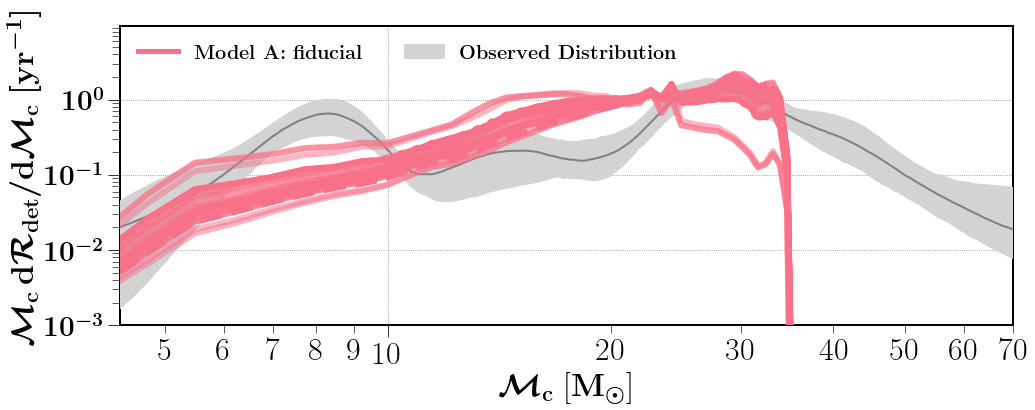

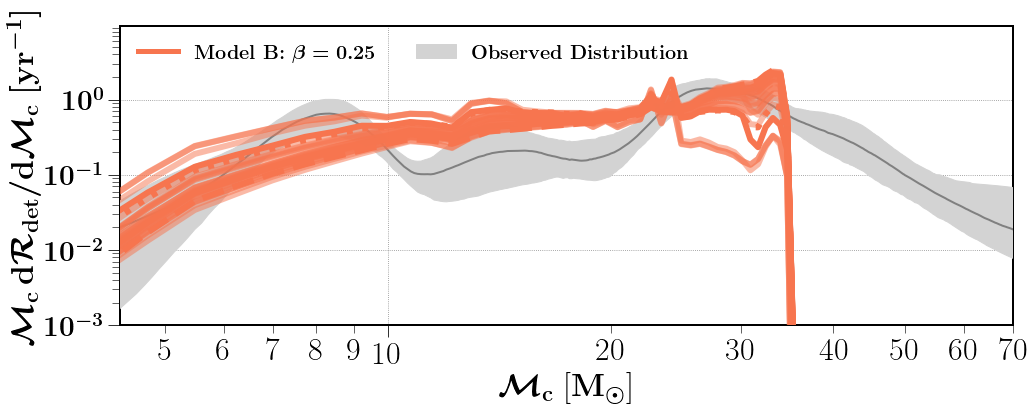

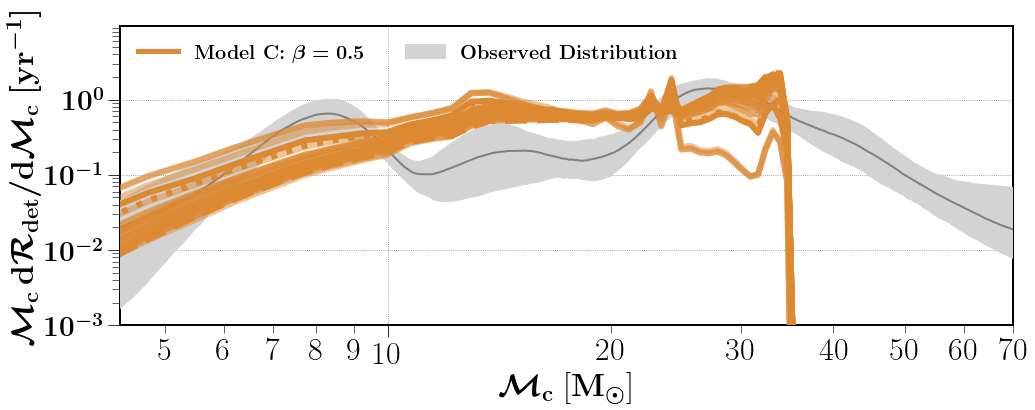

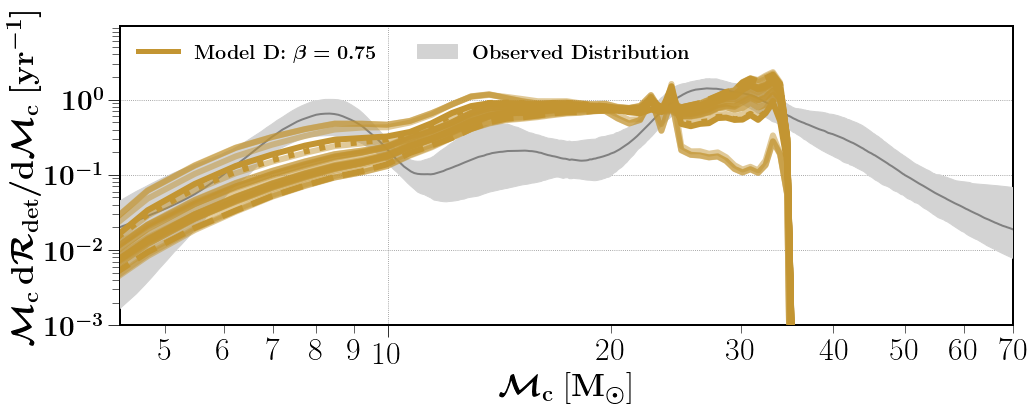

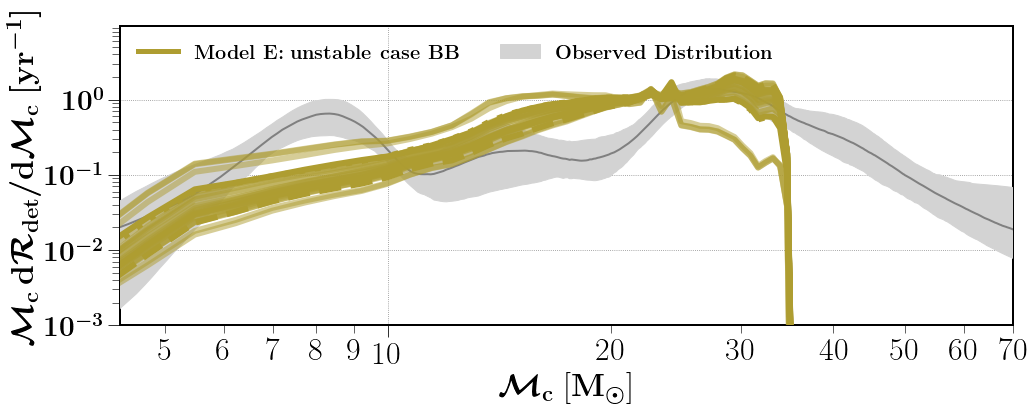

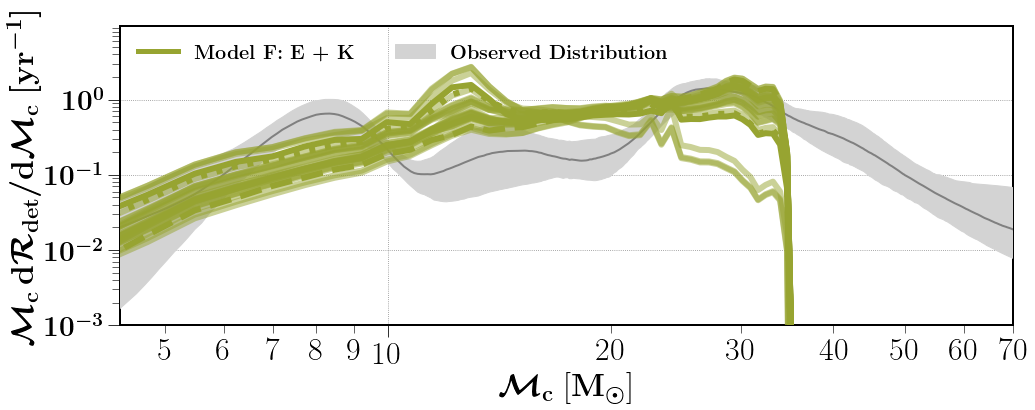

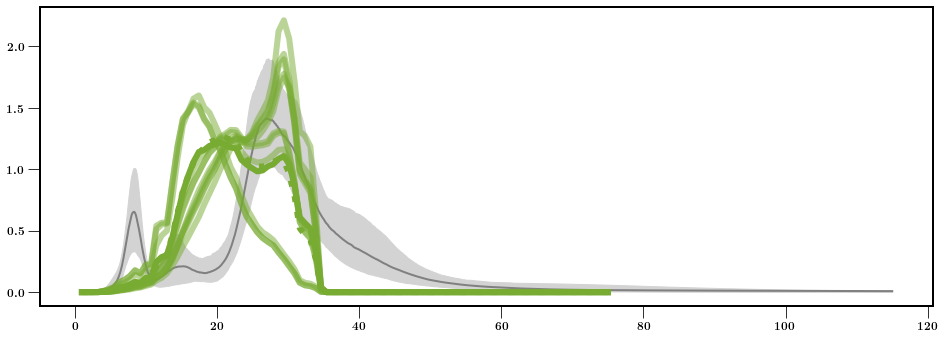

In [72]:
m1_ax = {}
mch_ax = {}
dRdm1 = {}
dRdmch = {}
pmch = {}
#Read files needed to make plots
fname =  PATH +'analyses/Vamana/posteriors/o1o2o3_sfr_1pz_rnp_ifar_1peryear_ng11.hdf5'
results = read_results(fname)
nobs = results['args_sampler']['nobs']
m1_ax['FM'] = results['args_ppd']['mass_ax']
mch_ax['FM'] = results['args_ppd']['mch_ax']
post_pdfs_mch = results['ppd']['post_pdf_mch']
post_pdfs_mass1 = results['ppd']['post_pdf_mass1']
rate = results['posteriors']['rate']
dRdmch['FM'] = (post_pdfs_mch.T * rate).T
dRdm1['FM'] = (post_pdfs_mass1.T * rate).T
dRdm1['FM']*=1.2**results['posteriors']['kappa']




with h5py.File(PATH +'analyses/Vamana/input/density_mchirp_standard_prior.hdf5', 'r') as bulk:
    mchax_pe = bulk['mchirp_ax'][()]
    density_mchirp_pe = bulk['density'][()]
    
# with h5py.File(PATH +'analyses/BinnedGP/O1O2O3_IFAR4/bbh_dRdm1.hdf', 'r') as bulk:
#     m1_ax['BGP'] = bulk['mass1'][()]
#     dRdm1['BGP'] = bulk['dRdm1'][()]

fname =PATH + 'analyses/AdaptiveKDE/Datafiles/kde_m1_Mchirp_100samplesPEperevent_values/'
fname += 'Mchirp_pe100samples_per_event_standard_bbh_events_kde_data_Mchirp_kde__5thp_50thp_95thp_Nevents_Nalp_Nbw.txt'
datakde = np.loadtxt(fname)
mch_ax['kde'] = datakde.T[0]
pmch['kde'] = datakde.T

# #Plot - overview
xlim_low = 5.
xlim_high = 100.



for BPSmodelName in BPSnameslist: #= 'G'
# for BPSmodelName in ['A']: #= 'G'
    ncols, nrows= 1,1
    fig, ax= plt.subplots(ncols=ncols,nrows=nrows,figsize=(16.0,  5.5), 
                  gridspec_kw={"width_ratios":1.5*np.ones(ncols), "height_ratios":1*np.ones(nrows)})
    # fig, ax  = plt.figure(figsize = (16.0, 2 * 5.5))


# plot posterior samples 
#     for density in density_mchirp_pe:
#     #     if ii == 0:
#     #         plt.plot(mchax_pe, density/10, color = 'grey', alpha = 0.5, label = 'Events Posterior')
#     #         ii += 1
#     #     else:
#         plt.plot(mchax_pe, mchax_pe*density/10, color = 'grey', alpha = 0.5, zorder=0)

    p50 = mch_ax['kde'] *pmch['kde'][3]
    p5 =  mch_ax['kde'] *pmch['kde'][2]
    p95 = mch_ax['kde'] *pmch['kde'][4]
    ax.plot(mch_ax['kde'], mch_ax['kde'] *pmch['kde'][3], color = 'gray', linewidth = 2.,zorder=4) # label = 'Observed Distribution',zorder=2)
    # ax.plot(mch_ax['kde'], pmch['kde'][2], color = 'k', linewidth = 2., linestyle = '--')
    # ax.plot(mch_ax['kde'], pmch['kde'][4], color = 'k', linewidth = 2., linestyle = '--')
    ax.fill_between(x=mch_ax['kde'], y1=mch_ax['kde'] * pmch['kde'][2], y2=mch_ax['kde'] *pmch['kde'][4], color = 'lightgray', zorder=3, label = r'$\textbf{Observed Distribution}$')



    # add location of the COMPAS hdf5 files:
    path_dir = '/Volumes/Andromeda2/DATA/AllDCO_bugfix/'
    TYPE,DCOtype = 'BBH', 'BBH'
    # GLOBAL SETTINGS 
    whichWeight='det' # which weighting we want (intrinisic or detecter)
    fs_t = 22
    # FIRST COLUMN WITH CHIRP MASS ###
    xparam, axe_ind, xlabelname ='ChirpMass', None,  r' $\mathcal{M}_{{c}}$ $ \,  [{M}_{\odot}]$' 
    # plot percentiles:


    # SFRDlist = MSSFRnameslist
    plot_mchirpkdes_single(axe=ax, axe_ind=axe_ind, xparam=xparam, BPSmodelNames=[BPSmodelName], MSSFRmodelNames=MSSFRnameslist, DCOtype=DCOtype, xvarrange=[1, 75], \
                                      whichWeight=whichWeight, path_dir=path_dir)


    l_ = r'$\textbf{Model %s:}$  %s'%(BPSmodelName, alphabetPhysicalNameDict[BPSmodelName])
    # 'Model %s'%(BPSmodelName)
    ax.plot([-1,-1], [-1,-1], c=colorDirDict[BPSmodelName],  lw=5, label=l_)
    plt.legend(fontsize=20, frameon=False, loc='upper left', ncol=2)
    # ax.text(0+0.009, 1-0.009, 'model %s%s \n %s'%(BPSmodelName,mssfr,alphabetPhysicalNameDict[BPSmodelName]),\
    #         rotation = 0, fontsize = fs+8, color = 'k', ha = 'left', va='top', transform=axe.transAxes, zorder=100)#, weight = 'bold')



    fontsize=28
    for tick in ax.xaxis.get_major_ticks():
        tick.label1.set_fontsize(fontsize+14)
        tick.label1.set_fontweight('bold')
    for tick in ax.yaxis.get_major_ticks():
        tick.label1.set_fontsize(fontsize)

        
    ax.set_yscale('log')
    plt.xscale('log')
    ax.set_xlim(2*xlim_low*0.25**(3/5), 70)
    ax.xaxis.set_major_formatter(FormatStrFormatter("%.0f"))
    ax.xaxis.set_minor_formatter(FormatStrFormatter("%.0f"))
    ax.xaxis.set_tick_params(labelsize=fontsize+4)
    
    ax.set_ylim(1E-3, 5 * np.max(p95))

    for tick in ax.xaxis.get_minor_ticks():
        tick.label1.set_fontweight('bold')
        tick.label1.set_fontsize(fontsize+4)
        

    ax.grid(ls=':',color='grey')

    ax.set_xlabel('$\mathcal{M}_{\mathrm{c}}$ [$\mathrm{M}_\odot$]',fontsize=fontsize+4, labelpad=2)
    ax.set_ylabel('$ \mathcal{M}_{\mathrm{c}} \, \mathrm{d}\mathcal{R}_{\mathrm{det}}/\mathrm{d} \mathcal{M}_{\mathrm{c}} \ [\mathrm{yr}^{-1}]$',fontsize=fontsize+4)




    plt.savefig('./pmch_together_loglogMchirp' + BPSmodelName + '.png', dpi = dpi, bbox_inches = 'tight')







# log 

In [ ]:
m1_ax = {}
mch_ax = {}
dRdm1 = {}
dRdmch = {}
pmch = {}
#Read files needed to make plots
fname =  PATH +'analyses/Vamana/posteriors/o1o2o3_sfr_1pz_rnp_ifar_1peryear_ng11.hdf5'
results = read_results(fname)
nobs = results['args_sampler']['nobs']
m1_ax['FM'] = results['args_ppd']['mass_ax']
mch_ax['FM'] = results['args_ppd']['mch_ax']
post_pdfs_mch = results['ppd']['post_pdf_mch']
post_pdfs_mass1 = results['ppd']['post_pdf_mass1']
rate = results['posteriors']['rate']
dRdmch['FM'] = (post_pdfs_mch.T * rate).T
dRdm1['FM'] = (post_pdfs_mass1.T * rate).T
dRdm1['FM']*=1.2**results['posteriors']['kappa']




with h5py.File(PATH +'analyses/Vamana/input/density_mchirp_standard_prior.hdf5', 'r') as bulk:
    mchax_pe = bulk['mchirp_ax'][()]
    density_mchirp_pe = bulk['density'][()]
    
# with h5py.File(PATH +'analyses/BinnedGP/O1O2O3_IFAR4/bbh_dRdm1.hdf', 'r') as bulk:
#     m1_ax['BGP'] = bulk['mass1'][()]
#     dRdm1['BGP'] = bulk['dRdm1'][()]

fname =PATH + 'analyses/AdaptiveKDE/Datafiles/kde_m1_Mchirp_100samplesPEperevent_values/'
fname += 'Mchirp_pe100samples_per_event_standard_bbh_events_kde_data_Mchirp_kde__5thp_50thp_95thp_Nevents_Nalp_Nbw.txt'
datakde = np.loadtxt(fname)
mch_ax['kde'] = datakde.T[0]
pmch['kde'] = datakde.T

# #Plot - overview
xlim_low = 5.
xlim_high = 100.



for BPSmodelName in ['K']:#, 'L', 'M', 'N', 'O', 'P', 'Q', 'R', 'S', 'T']: #= 'G'

    ncols, nrows= 1,1
    fig, ax= plt.subplots(ncols=ncols,nrows=nrows,figsize=(16.0,  5.5), 
                  gridspec_kw={"width_ratios":1.5*np.ones(ncols), "height_ratios":1*np.ones(nrows)})
    # fig, ax  = plt.figure(figsize = (16.0, 2 * 5.5))


    #plot posterior samples 
    # plt.subplot(2, 1, 1)
    # ii = 0
    for density in density_mchirp_pe:
    #     if ii == 0:
    #         plt.plot(mchax_pe, density/10, color = 'grey', alpha = 0.5, label = 'Events Posterior')
    #         ii += 1
    #     else:
        plt.plot(mchax_pe, density/30, color = 'grey', alpha = 0.5, zorder=0)

    p50 = pmch['kde'][3]
    p5 =  pmch['kde'][2]
    p95 = pmch['kde'][4]
    ax.plot(mch_ax['kde'], pmch['kde'][3], color = 'gray', linewidth = 2.,zorder=4) # label = 'Observed Distribution',zorder=2)
    # ax.plot(mch_ax['kde'], pmch['kde'][2], color = 'k', linewidth = 2., linestyle = '--')
    # ax.plot(mch_ax['kde'], pmch['kde'][4], color = 'k', linewidth = 2., linestyle = '--')
    ax.fill_between(x=mch_ax['kde'], y1=pmch['kde'][2], y2=pmch['kde'][4], color = 'lightgray', zorder=3, label = 'Observed Distribution')



    # add location of the COMPAS hdf5 files:
    path_dir = '/Volumes/Andromeda/DATA/AllDCO_bugfix/'
    TYPE,DCOtype = 'BBH', 'BBH'
    # GLOBAL SETTINGS 
    whichWeight='det' # which weighting we want (intrinisic or detecter)
    fs_t = 22
    # FIRST COLUMN WITH CHIRP MASS ###
    xparam, axe_ind, xlabelname ='ChirpMass', None,  r' $\mathcal{M}_{{c}}$ $ \,  [{M}_{\odot}]$' 
    # plot percentiles:


    # SFRDlist = MSSFRnameslist
    plot_kdes_single(axe=ax, axe_ind=axe_ind, xparam=xparam, BPSmodelNames=[BPSmodelName], MSSFRmodelNames=['112'], DCOtype=DCOtype, xvarrange=[1, 75], \
                                      whichWeight=whichWeight, path_dir=path_dir)


    l_ = 'model %s: \n %s'%(BPSmodelName, alphabetPhysicalNameDict[BPSmodelName])
    # 'Model %s'%(BPSmodelName)
    ax.plot([-1,-1], [-1,-1], c=colorDirDict[BPSmodelName],  lw=5, label=l_)
    plt.legend(fontsize=20, frameon=False, loc='upper right')
    # ax.text(0+0.009, 1-0.009, 'model %s%s \n %s'%(BPSmodelName,mssfr,alphabetPhysicalNameDict[BPSmodelName]),\
    #         rotation = 0, fontsize = fs+8, color = 'k', ha = 'left', va='top', transform=axe.transAxes, zorder=100)#, weight = 'bold')



    fontsize=24
    for tick in ax.xaxis.get_major_ticks():
        tick.label1.set_fontsize(fontsize)
        tick.label1.set_fontweight('bold')
    for tick in ax.yaxis.get_major_ticks():
        tick.label1.set_fontsize(fontsize)


#     ax.set_yscale('log')
    plt.xscale('log')
    ax.set_xlim(2*xlim_low*0.25**(3/5), 70)
    ax.xaxis.set_major_formatter(FormatStrFormatter("%.0f"))
    ax.xaxis.set_minor_formatter(FormatStrFormatter("%.0f"))
    ax.set_ylim(0, 1.05 * np.max(p95))



    ax.grid(ls=':',color='grey')

    ax.set_xlabel('$\mathcal{M}_{\mathrm{c}}$ [$\mathrm{M}_\odot$]',fontsize=fontsize+2, labelpad=2)
    ax.set_ylabel('$\, \mathrm{d}\mathcal{R}_{\mathrm{det}}/\mathrm{d} \mathcal{M}_{\mathrm{c}} \ [\mathrm{M}_{\odot}^{-1} ]$ ',fontsize=fontsize+2)




    plt.savefig('./pmch_together_lin' + BPSmodelName + '.png', dpi = dpi, bbox_inches = 'tight')







In [ ]:
m1_ax = {}
mch_ax = {}
dRdm1 = {}
dRdmch = {}
pmch = {}
#Read files needed to make plots
fname =  PATH +'analyses/Vamana/posteriors/o1o2o3_sfr_1pz_rnp_ifar_1peryear_ng11.hdf5'
results = read_results(fname)
nobs = results['args_sampler']['nobs']
m1_ax['FM'] = results['args_ppd']['mass_ax']
mch_ax['FM'] = results['args_ppd']['mch_ax']
post_pdfs_mch = results['ppd']['post_pdf_mch']
post_pdfs_mass1 = results['ppd']['post_pdf_mass1']
rate = results['posteriors']['rate']
dRdmch['FM'] = (post_pdfs_mch.T * rate).T
dRdm1['FM'] = (post_pdfs_mass1.T * rate).T
dRdm1['FM']*=1.2**results['posteriors']['kappa']




with h5py.File(PATH +'analyses/Vamana/input/density_mchirp_standard_prior.hdf5', 'r') as bulk:
    mchax_pe = bulk['mchirp_ax'][()]
    density_mchirp_pe = bulk['density'][()]
    
# with h5py.File(PATH +'analyses/BinnedGP/O1O2O3_IFAR4/bbh_dRdm1.hdf', 'r') as bulk:
#     m1_ax['BGP'] = bulk['mass1'][()]
#     dRdm1['BGP'] = bulk['dRdm1'][()]

fname =PATH + 'analyses/AdaptiveKDE/Datafiles/kde_m1_Mchirp_100samplesPEperevent_values/'
fname += 'Mchirp_pe100samples_per_event_standard_bbh_events_kde_data_Mchirp_kde__5thp_50thp_95thp_Nevents_Nalp_Nbw.txt'
datakde = np.loadtxt(fname)
mch_ax['kde'] = datakde.T[0]
pmch['kde'] = datakde.T

# #Plot - overview
xlim_low = 5.
xlim_high = 100.



for BPSmodelName in ['K']:#, 'L', 'M', 'N', 'O', 'P', 'Q', 'R', 'S', 'T']: #= 'G'

    ncols, nrows= 1,1
    fig, ax= plt.subplots(ncols=ncols,nrows=nrows,figsize=(16.0,  5.5), 
                  gridspec_kw={"width_ratios":1.5*np.ones(ncols), "height_ratios":1*np.ones(nrows)})
    # fig, ax  = plt.figure(figsize = (16.0, 2 * 5.5))


    #plot posterior samples 
    # plt.subplot(2, 1, 1)
    # ii = 0
    for density in density_mchirp_pe:
    #     if ii == 0:
    #         plt.plot(mchax_pe, density/10, color = 'grey', alpha = 0.5, label = 'Events Posterior')
    #         ii += 1
    #     else:
        plt.plot(mchax_pe, density/30, color = 'grey', alpha = 0.5, zorder=0)

    p50 = pmch['kde'][3]
    p5 =  pmch['kde'][2]
    p95 = pmch['kde'][4]
    ax.plot(mch_ax['kde'], pmch['kde'][3], color = 'gray', linewidth = 2.,zorder=4) # label = 'Observed Distribution',zorder=2)
    # ax.plot(mch_ax['kde'], pmch['kde'][2], color = 'k', linewidth = 2., linestyle = '--')
    # ax.plot(mch_ax['kde'], pmch['kde'][4], color = 'k', linewidth = 2., linestyle = '--')
    ax.fill_between(x=mch_ax['kde'], y1=pmch['kde'][2], y2=pmch['kde'][4], color = 'lightgray', zorder=3, label = 'Observed Distribution')



    # add location of the COMPAS hdf5 files:
    path_dir = '/Volumes/Andromeda/DATA/AllDCO_bugfix/'
    TYPE,DCOtype = 'BBH', 'BBH'
    # GLOBAL SETTINGS 
    whichWeight='det' # which weighting we want (intrinisic or detecter)
    fs_t = 22
    # FIRST COLUMN WITH CHIRP MASS ###
    xparam, axe_ind, xlabelname ='ChirpMass', None,  r' $\mathcal{M}_{{c}}$ $ \,  [{M}_{\odot}]$' 
    # plot percentiles:


    # SFRDlist = MSSFRnameslist
    plot_kdes_single(axe=ax, axe_ind=axe_ind, xparam=xparam, BPSmodelNames=[BPSmodelName], MSSFRmodelNames=['112'], DCOtype=DCOtype, xvarrange=[1, 75], \
                                      whichWeight=whichWeight, path_dir=path_dir)


    l_ = 'model %s: \n %s'%(BPSmodelName, alphabetPhysicalNameDict[BPSmodelName])
    # 'Model %s'%(BPSmodelName)
    ax.plot([-1,-1], [-1,-1], c=colorDirDict[BPSmodelName],  lw=5, label=l_)
    plt.legend(fontsize=20, frameon=False, loc='upper right')
    # ax.text(0+0.009, 1-0.009, 'model %s%s \n %s'%(BPSmodelName,mssfr,alphabetPhysicalNameDict[BPSmodelName]),\
    #         rotation = 0, fontsize = fs+8, color = 'k', ha = 'left', va='top', transform=axe.transAxes, zorder=100)#, weight = 'bold')



    fontsize=24
    for tick in ax.xaxis.get_major_ticks():
        tick.label1.set_fontsize(fontsize)
        tick.label1.set_fontweight('bold')
    for tick in ax.yaxis.get_major_ticks():
        tick.label1.set_fontsize(fontsize)


#     ax.set_yscale('log')
    plt.xscale('log')
    ax.set_xlim(2*xlim_low*0.25**(3/5), 70)
    ax.xaxis.set_major_formatter(FormatStrFormatter("%.0f"))
    ax.xaxis.set_minor_formatter(FormatStrFormatter("%.0f"))
    ax.set_ylim(0, 1.05 * np.max(p95))



    ax.grid(ls=':',color='grey')

    ax.set_xlabel('$\mathcal{M}_{\mathrm{c}}$ [$\mathrm{M}_\odot$]',fontsize=fontsize+2, labelpad=2)
    ax.set_ylabel('$\, \mathrm{d}\mathcal{R}_{\mathrm{det}}/\mathrm{d} \mathcal{M}_{\mathrm{c}} \ [\mathrm{M}_{\odot}^{-1} ]$ ',fontsize=fontsize+2)




    plt.savefig('./pmch_together_mchirplog' + BPSmodelName + '.png', dpi = dpi, bbox_inches = 'tight')







now at m= G
/Volumes/Andromeda/DATA/AllDCO_bugfix/alpha0_1/COMPASCompactOutput_BBH_G.h5
['112']
0.9997528274305674


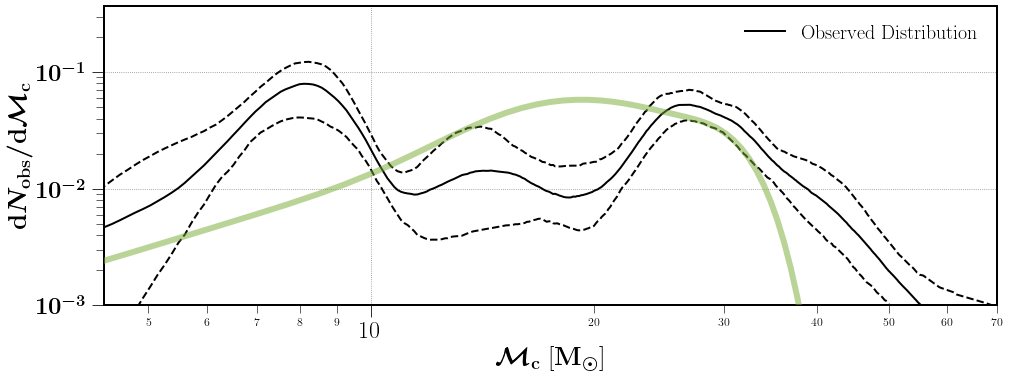

In [39]:
m1_ax = {}
mch_ax = {}
dRdm1 = {}
dRdmch = {}
pmch = {}
#Read files needed to make plots
fname =  PATH +'analyses/Vamana/posteriors/o1o2o3_sfr_1pz_rnp_ifar_1peryear_ng11.hdf5'
results = read_results(fname)
nobs = results['args_sampler']['nobs']
m1_ax['FM'] = results['args_ppd']['mass_ax']
mch_ax['FM'] = results['args_ppd']['mch_ax']
post_pdfs_mch = results['ppd']['post_pdf_mch']
post_pdfs_mass1 = results['ppd']['post_pdf_mass1']
rate = results['posteriors']['rate']
dRdmch['FM'] = (post_pdfs_mch.T * rate).T
dRdm1['FM'] = (post_pdfs_mass1.T * rate).T
dRdm1['FM']*=1.2**results['posteriors']['kappa']




with h5py.File(PATH +'analyses/Vamana/input/density_mchirp_standard_prior.hdf5', 'r') as bulk:
    mchax_pe = bulk['mchirp_ax'][()]
    density_mchirp_pe = bulk['density'][()]
    
# with h5py.File(PATH +'analyses/BinnedGP/O1O2O3_IFAR4/bbh_dRdm1.hdf', 'r') as bulk:
#     m1_ax['BGP'] = bulk['mass1'][()]
#     dRdm1['BGP'] = bulk['dRdm1'][()]

fname =PATH + 'analyses/AdaptiveKDE/Datafiles/kde_m1_Mchirp_100samplesPEperevent_values/'
fname += 'Mchirp_pe100samples_per_event_standard_bbh_events_kde_data_Mchirp_kde__5thp_50thp_95thp_Nevents_Nalp_Nbw.txt'
datakde = np.loadtxt(fname)
mch_ax['kde'] = datakde.T[0]
pmch['kde'] = datakde.T

# #Plot - overview
xlim_low = 5.
xlim_high = 100.

ncols, nrows= 1,1
fig, ax= plt.subplots(ncols=ncols,nrows=nrows,figsize=(16.0,  5.5), 
              gridspec_kw={"width_ratios":1.5*np.ones(ncols), "height_ratios":1*np.ones(nrows)})
# fig, ax  = plt.figure(figsize = (16.0, 2 * 5.5))


# plot posterior samples 
# plt.subplot(2, 1, 1)
# ii = 0
# for density in density_mchirp_pe:
#     if ii == 0:
#         plt.plot(mchax_pe, density/10, color = 'grey', alpha = 0.5, label = 'Events Posterior')
#         ii += 1
#     else:
#         plt.plot(mchax_pe, density/10, color = 'grey', alpha = 0.5)

p50 = pmch['kde'][3]
p5 =  pmch['kde'][2]
p95 = pmch['kde'][4]
ax.plot(mch_ax['kde'], pmch['kde'][3], color = 'k', linewidth = 2., label = 'Observed Distribution')
ax.plot(mch_ax['kde'], pmch['kde'][2], color = 'k', linewidth = 2., linestyle = '--')
ax.plot(mch_ax['kde'], pmch['kde'][4], color = 'k', linewidth = 2., linestyle = '--')

plt.legend(fontsize=20, frameon=False, loc='upper right')

# add location of the COMPAS hdf5 files:
path_dir = '/Volumes/Andromeda/DATA/AllDCO_bugfix/'
TYPE,DCOtype = 'BBH', 'BBH'
# GLOBAL SETTINGS 
whichWeight='det' # which weighting we want (intrinisic or detecter)
fs_t = 22
# FIRST COLUMN WITH CHIRP MASS ###
xparam, axe_ind, xlabelname ='ChirpMass', None,  r' $\mathcal{M}_{{c}}$ $ \,  [{M}_{\odot}]$' 
# plot percentiles:
plot_kdes_single(axe=ax, axe_ind=axe_ind, xparam=xparam, BPSmodelNames=['G'], MSSFRmodelNames=['112'], DCOtype=DCOtype, xvarrange=[1, 75], \
                              whichWeight=whichWeight, path_dir=path_dir)



fontsize=24
for tick in ax.xaxis.get_major_ticks():
    tick.label1.set_fontsize(fontsize)
#     tick.label1.set_fontweight('bold')
for tick in ax.yaxis.get_major_ticks():
    tick.label1.set_fontsize(fontsize)


ax.set_yscale('log')
ax.set_xscale('log')

ax.xaxis.set_major_formatter(FormatStrFormatter("%.0f"))
ax.xaxis.set_minor_formatter(FormatStrFormatter("%.0f"))

ax.set_ylim(1e-3, 3.0 * np.max(p95))
ax.set_xlim(2*xlim_low*0.25**(3/5), 70)



ax.grid(ls=':',color='grey')

ax.set_xlabel('$\mathcal{M}_{\mathrm{c}}$ [$\mathrm{M}_\odot$]',fontsize=fontsize+2, labelpad=2)
ax.set_ylabel('$\, \mathrm{d}N_{\mathrm{obs}}/\mathrm{d} \mathcal{M}_{\mathrm{c}}$',fontsize=fontsize+2)




plt.savefig(PATH +'figures/pmch_together_logx.png', dpi = dpi, bbox_inches = 'tight')





